# Transfer Learning Using Dogs vs Cats Kaggle Dataset

## What is Transfer Learning and why do we use it?

In the context of deep learning, tranfer learning is when model exploits the knowledge gained from a previous task to improve generalization when approaching a new problem

In this notebook we utilize transfer learning by using the convolutional network VGG16 which has been pretrained on the massive imagenet dataset.  When being trained on the imagenet dataset this VGG16 network was tasked with deciding between 1000 categories of objects for how to classify images.  The key thing to note is that amongst these 1,000 classes there are a number of classes related to cats and dogs (including but not limited to: Greater Swiss Mountain dog, Bernese mountain dog, Maltese dog,Shih-Tzu, tiger cat, Persian cat, and Siamese cat).  

VGG16 has been one of the top performing CNN models on the imagenet dataset.  Thus we are wondering if we can use that VGG19 has used while training on imagenet and apply it to a kaggle dataset where we are only concerned with telling the difference between cats and dogs!  


## Data Preparation

Since this was an older dataset we were having a hard time downloading the data from Kaggle using the kaggle API (on google colab).  We had been successful downloading more recent datasets like the Flowers102 dataset from kaggle using the API so we expect to switch back if we look into the Flowers102 dataset in the coming weeks. Thus we ended up downloading it manually and then we had to process it by separating all of the dog and cat images into their own folders in the same directory as a normal jupyter notebook (not on colab).

In [76]:
import os
print(os.getcwd())
# import the needed packages
import matplotlib.pyplot as plt
import matplotlib.image as img
from tensorflow import keras
# shortcut to the ImageDataGenerator class
ImageDataGenerator = keras.preprocessing.image.ImageDataGenerator

/Users/jacksoncurry/Desktop/School Files/DeepLearning/Report 5


## Dogs Vs Cats Dataset Exploration

In the cell below we show the first cat and dog image in the dataset.  Something we realized immediately was that the images were different sizes!  This is different from the Cifar10 and MNIST datasets that we have been mainly using thus far.  This was the moment when we realized how much more preprocessing we were going to have to do for this dataset and started missing the familiar Cifar10 and MNIST datasets.  We realize that this new dataset is much more realistic for what a real-world dataset might look like so we thought it was worth pushing through figuring out how to process it!

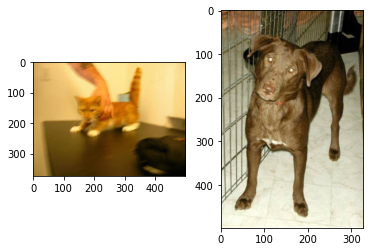

In [77]:
plt.subplot(1,2,1)
plt.imshow(img.imread('cats/cat.0.jpg'))
plt.subplot(1,2,2)
plt.imshow(img.imread('dogs/dog.1.jpg'))

In the section below we create a scatterplot that shows the x and y dimensions of the first 3000 images in the dataset.  Some interesting things to note from this figure are that there appears to be a ton of images that have either a height of 500 pixels or a width of 500 pixels (resulting in the rotated L shape that appears in the scatter plot).  Another thing to note is that the width and height are positively correlated which makes sense because most pictures of cats and dogs are roughly square.  

Finally we can see that there is an outlier in this dataset that has much larger dimensions than all of the other images!  We may have to keep our eye out and think about removing this particular image if it starts causing us a lot of trouble somewhere in the future so it is good to see now!

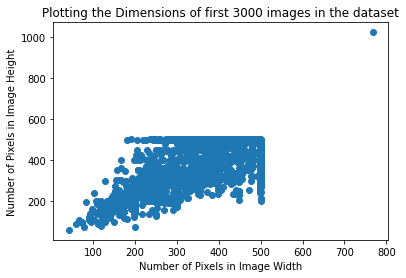

In [83]:
images = []
xNumPixels = []
yNumPixels = []
for i in range(3000):
  im = img.imread('cats/cat.{}.jpg'.format(i))
  images.append(im)
  #print('image shape', im.shape, 'maximum color level', im.max())
  xNumPixels.append(im.shape[0])
  yNumPixels.append(im.shape[1])

plt.scatter(xNumPixels,yNumPixels)
plt.xlabel("Number of Pixels in Image Width")
plt.ylabel("Number of Pixels in Image Height")
plt.title("Plotting the Dimensions of first 3000 images in the dataset")
plt.show()

Looking a bit closer at the images themselves (just in the folder) we saw a couple of images that stood out to us because they made no sense at all!  Below we visualize these images and we can see that a couple images in each category are either just random images or they have been classified wrong (putting an image of a cat into the dog dataset or vice versa).  We assume that this is just an additional challenge that may have been artificially created for the kaggle competition, but it does teach us that it is important to at least look into the data itself more closely to make sure it isn't incorrect or flawed.

In [85]:
bad_dog_ids = [5604, 6413, 8736, 8898, 9188, 9517, 10161,10190]

bad_cat_ids = [2939, 3216, 4688, 4833, 5418, 6215, 7377]

In [86]:
def load_images(ids, categ):
  '''return the images corresponding to a list of ids'''
  images = []
  dirname = categ+'s' # dog -> dogs
  for theid in ids: 
    fname = '{dirname}/{categ}.{theid}.jpg'.format(
        dirname=dirname,
        categ=categ, 
        theid=theid
    )
    im = img.imread(fname)
    images.append(im)
  return images

In [87]:
bad_dogs = load_images(bad_dog_ids, 'dog')
bad_cats = load_images(bad_cat_ids, 'cat')

In [88]:
def plot_images(images, ids):
    ncols, nrows = 4, 3
    fig = plt.figure( figsize=(ncols*3, nrows*3), dpi=90)
    for i, (img, theid) in enumerate(zip(images,ids)):
      plt.subplot(nrows, ncols, i+1)
      plt.imshow(img)
      plt.title(str(theid))
      plt.axis('off')
    

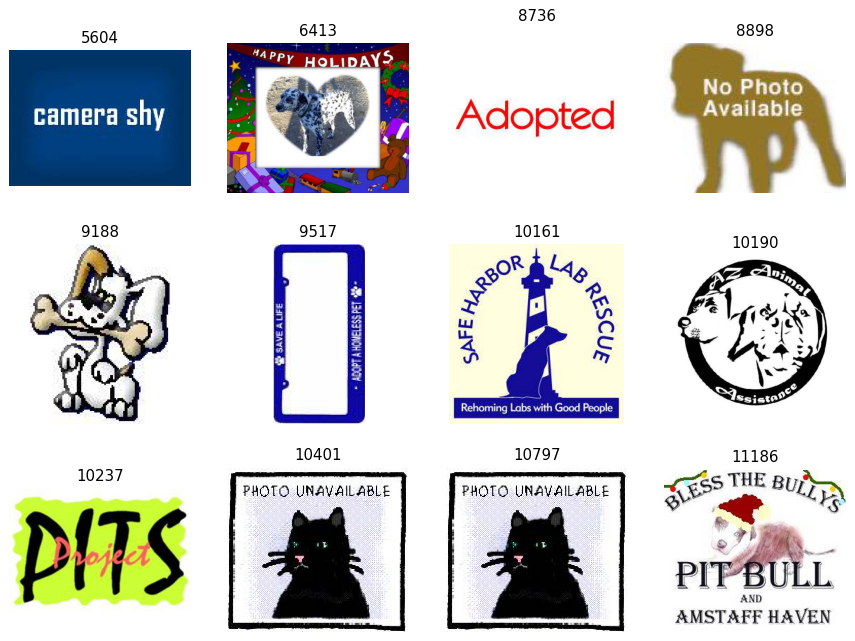

In [8]:
plot_images(bad_dogs, bad_dog_ids)

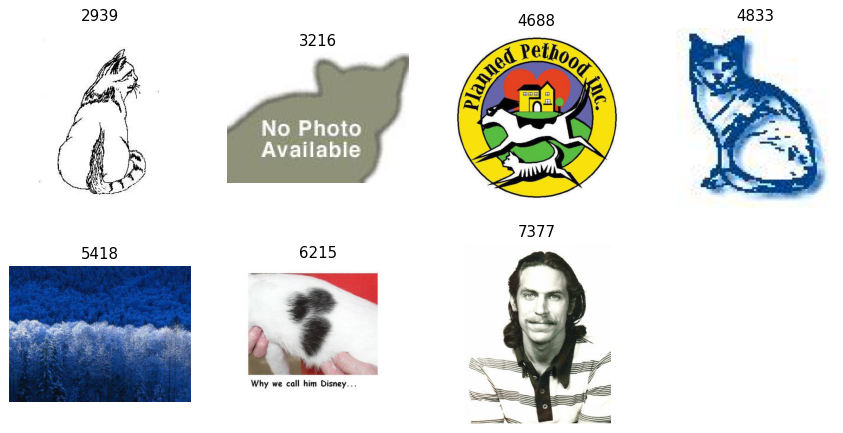

In [89]:
plot_images(bad_cats, bad_cat_ids)

In [10]:
currBatch = 30

#Below is a generator function in order to create the training and validation dataset with an input desired shape
#When we call this function we call it with the shape being 244x244 meaning that we want all of the images to be
#scaled so that they become a normal shape of 244x244
def generators(shape, preprocessing): 
    imgdatagen = ImageDataGenerator(
        preprocessing_function = preprocessing,
        horizontal_flip = True, 
        validation_split = 0.1,
    )

    height, width = shape      

    #using imgdatagen.flow_from_directory to pull data from the folders I made for the data!
    train_dataset = imgdatagen.flow_from_directory(          
        os.getcwd(),
        target_size = (height, width), 
        classes = ('dogs','cats'),
        batch_size = currBatch,
        subset = 'training', 
    )

    val_dataset = imgdatagen.flow_from_directory(
        os.getcwd(),
        target_size = (height, width), 
        classes = ('dogs','cats'),
        batch_size = currBatch,
        subset = 'validation'
    )
    return train_dataset, val_dataset

## Loading in VGG16 Pretrained on Imagenet and Altering Structure to Fit Our Need

In this section we load in the VGG16 model with the weights that it has gotten from training on the massive imagenet dataset (we are hoping that these pretrained weights will be generalizable to helping us classify our current dataset).  Also another thing to note is that the output layer of VGG16 from imagenet is 1000 since there are 1000 possible categories.  However for our current use case we only have 2 categories so we still need to update the structure of this network and add in another layer for training to make it perform well.

In [12]:
vgg16 = keras.applications.vgg16
conv_model = vgg16.VGG16(weights='imagenet', include_top=False) #It is important to use the include_top=False
                                                         #because imagenet has 1000 categories but now we only
                                                         #have 2 categories!
conv_model.summary()

2021-11-03 04:59:54.630403: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [13]:
from tensorflow.keras.preprocessing import image
import numpy as np

img_path = 'dogs/dog.1.jpg'

# loading the image: 
img = image.load_img(img_path, target_size=(224, 224))
# turn it into a numpy array
x = image.img_to_array(img)
print(np.min(x), np.max(x))
print(x.shape)
# expand the shape of the array, 
# a new axis is added at the beginning:
xs = np.expand_dims(x, axis=0)
print(xs.shape)
# preprocess input array for VGG16
xs = vgg16.preprocess_input(xs)
# evaluate the model to extract the features
features = conv_model.predict(xs)
print(features.shape)

0.0 255.0
(224, 224, 3)
(1, 224, 224, 3)


2021-11-03 04:59:55.258429: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


(1, 7, 7, 512)


Here we call our helper function from above in order to process our dog and cat image data and scale it to 224x224
so we can have some normalized input shape for our current model

In [14]:
train_dataset, val_dataset = generators((224,224), preprocessing=vgg16.preprocess_input) 

Found 22500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [15]:
conv_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))

In the cell below we flatten the pretrained output from the VGG16 network.  We then add a hidden layer to connect the pretrained convolution to the output layer. This layer will have trainable weights that will be determined using the new dataset!

In [16]:
# flatten output of the pretrained convolutional part of VGG16 
x = keras.layers.Flatten()(conv_model.output)
# adding a hidden layer to connect the pretrained convolution to the output layer. This layer needs trainable weights!
x = keras.layers.Dense(20, activation='relu')(x)
# final softmax layer with two categories (dog and cat)
predictions = keras.layers.Dense(2, activation='softmax')(x)

# creating the full model:
full_model = keras.models.Model(inputs=conv_model.input, outputs=predictions)
full_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

This is where we make all of the convolutional pretrained layers of VGG16 non-trainable so that our model is
more generalizable and uses the stuff it learned from imagenet!  When I print out the structure of the model below the largest thing to note is that the number of trainable parameters is now only 501,822 instad of 15,216,510.

In [17]:
for layer in conv_model.layers:
    layer.trainable = False

In [18]:
full_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In the cell below we train our new full model that utilizes transfer learning for 1 epoch.  Amazingly enough we see that after only 1 epoch (which did take 4280 seconds to train) we already reach an accuracy of 97% for classifying dogs and cats correctly!  This is quite impressive and definitely showcases how much the model learned about dogs and cats in general when it was pretrained on the imagenet dataset.

In [20]:
full_model.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.Adamax(learning_rate=0.001),
                  metrics=['acc'])
history = full_model.fit_generator(
    train_dataset, 
    validation_data = val_dataset,
    workers=10,
    epochs=1,
)

/Applications/anaconda3/envs/deepLearning/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
/Applications/anaconda3/envs/deepLearning/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


750/750 [==============================] - 4280s 6s/step - loss: 0.1478 - acc: 0.9735 - val_loss: 0.0868 - val_acc: 0.9748


## Saving a good model for later:

Below we show how we learned how to save the weights of this model so that we never have to train it again! This is great because this gives us the capability to load this pre-trained model that we have personally trained when we are about to start a new project.  This pretrained model can then be used to make future predictions in another notebook, or can function as a "teacher" model in a distillation model!

In [21]:
full_model.save('vgg16Trained')

2021-11-03 09:19:52.756343: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: vgg16Trained/assets


Below we show how you can load in this model that we just saved to a folder above!

In [32]:
myPretrainedModel = keras.models.load_model("vgg16Trained")

In the cell below we have our trained model and our model we just loaded from the save folder make predictions for other images.  We can see that the predictions are the exact same so our saved model works the same!  We also can see that the confidence levels for these normal images are very high (in the first image below the network essentially 100% confident that the image is a cat which translates to the value 1.0000000e+00 for confidence which is very very close to 1)

[[8.0376044e-19 1.0000000e+00]]
[[8.0376044e-19 1.0000000e+00]]


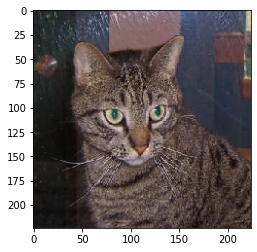

[[1.000000e+00 8.237853e-19]]
[[1.000000e+00 8.237853e-19]]


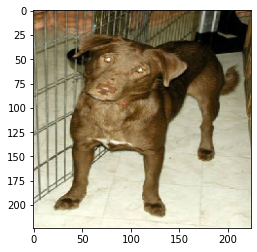

In [48]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

img_path = 'cats/cat.1.jpg'
img = image.load_img(img_path, target_size=(224,224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
print(full_model.predict(x))
print(myPretrainedModel.predict(x))
plt.imshow(img)
plt.show()

img_path = 'dogs/dog.1.jpg'
img = image.load_img(img_path, target_size=(224,224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
print(full_model.predict(x))
print(myPretrainedModel.predict(x))
plt.imshow(img)
plt.show()

### What about if we try one of the bad dog/cat images we had found from above?
Here we can see that the confidence levels go down from being very close to 1 when we have a bad/confusing image.  We note that the saved model still acts the exact same as the trained model!

[[0.7584042  0.24159577]]
[[0.7584042  0.24159577]]


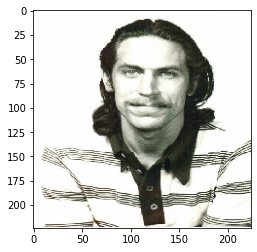

[[9.9973351e-01 2.6644714e-04]]
[[9.9973351e-01 2.6644714e-04]]
0.9997335


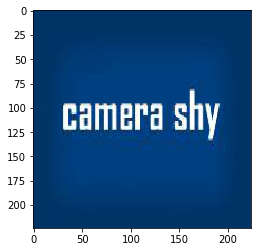

In [54]:
img_path = 'cats/cat.7377.jpg'
img = image.load_img(img_path, target_size=(224,224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
print(full_model.predict(x))
print(myPretrainedModel.predict(x))
plt.imshow(img)
plt.show()

img_path = 'dogs/dog.5604.jpg'
img = image.load_img(img_path, target_size=(224,224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
print(full_model.predict(x))
print(myPretrainedModel.predict(x))
currConfidence = myPretrainedModel.predict(x)
print(currConfidence[0][0])
plt.imshow(img)
plt.show()

In the cells below we look at how confident our trained model is when predicting a class for the first 5000 images in the dataset.  We can generally see that our network is very confident in its decisions which makes sense because it performed so well!  We also created the histograms below to visualize this confidence pdf.  We can see that the confidence values are extremely skewed to the right and left edges meaning the network was very confident most of the time.  

In order to make a more interesting visualization we changed the y axis in the second plot to be log scaled.  This makes the few outliers in the middle (where our network was unsure) more visible.  We believe that many of these outliers might be some of the strange images we found in the dataset during our exploratory analysis of the dataset!

In [72]:
#creating a histogram of these values for both dogs and cats to show the confidence levels
dogConfidences = []
catConfidences = []
for i in range (5000):
    dogPath = 'dogs/dog.'+str(i+1)+'.jpg'
    catPath = 'cats/cat.'+str(i+1)+'.jpg'
    dogImg = image.load_img(dogPath, target_size=(224,224))
    catImg = image.load_img(catPath, target_size=(224,224))
    dogx = image.img_to_array(dogImg)
    dogx = np.expand_dims(dogx, axis=0)
    dogx = preprocess_input(dogx)
    currConfidence = myPretrainedModel.predict(dogx)
    dogConfidences.append(currConfidence[0][0])
    
    catx = image.img_to_array(catImg)
    catx = np.expand_dims(catx, axis=0)
    catx = preprocess_input(catx)
    currConfidence = myPretrainedModel.predict(catx)
    catConfidences.append(currConfidence[0][0])
    if i%100 == 0:
        print(i)

    

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900


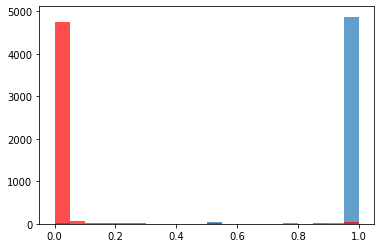

In [73]:
#Now plotting a histogram of both the cat and dog confidences
plt.hist(dogConfidences, bins=20, alpha=0.7)
plt.hist(catConfidences, bins=20, alpha=0.7, color = 'r')
plt.show()


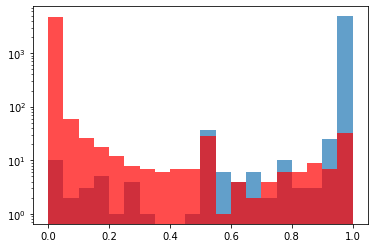

In [74]:
#Now plotting a histogram of both the cat and dog confidences
plt.hist(dogConfidences, bins=20, alpha=0.7)
plt.hist(catConfidences, bins=20, alpha=0.7, color = 'r')
plt.yscale('log')
plt.show()